In [1]:
# Install library
%pip install azure-ai-documentintelligence
%pip install azure-ai-formrecognizer

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import configparser
from azure.core.credentials import AzureKeyCredential
from azure.ai.formrecognizer import DocumentAnalysisClient
config = configparser.ConfigParser()
envpath="/home/azureuser/localfiles/TEDI.ini"
config.read(envpath)
api_key = config.get('DocumentAI', 'key')
# an endpoint is a URL at which a web service can be accessed by a client application.
endpoint = config.get('DocumentAI', 'endpoint')
model_id = 'invoice-pretrain-ref'
document_analysis_client = DocumentAnalysisClient(
    endpoint=endpoint, credential=AzureKeyCredential(api_key)
)    

In [13]:
from pathlib import Path
img_dir = Path('/home/azureuser/cloudfiles/code/dataset')
mcocr_dir = img_dir/'mcocr_val_data/val_images'
file_path = mcocr_dir/'mcocr_val_145114aszbc.jpg'
model_id = 'invoice-pretrain-ref'

if not file_path.exists():
    raise FileNotFoundError(f'File {file_path} not found')


# Make sure your document's type is included in the list of document types the custom model can analyze
with open(file_path, "rb") as f:
    poller = document_analysis_client.begin_analyze_document(
        model_id=model_id, document=f
    )
result = poller.result()

In [16]:
result.documents[0].fields

{'InvoiceDate': DocumentField(value_type=date, value=None, content=15/08/2020, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=278.0, y=319.0), Point(x=376.0, y=322.0), Point(x=375.0, y=345.0), Point(x=277.0, y=342.0)])], spans=[DocumentSpan(offset=145, length=10)], confidence=0.921),
 'SubTotal': DocumentField(value_type=string, value='22.000', content=22.000, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=541.0, y=499.0), Point(x=600.0, y=500.0), Point(x=600.0, y=516.0), Point(x=541.0, y=515.0)])], spans=[DocumentSpan(offset=308, length=6)], confidence=0.938),
 'VendorAddress': DocumentField(value_type=string, value='Số 463, Tổ 66, Khu Diêm Thủy P. Câm Động, TP. Cầm Phá', content=Số 463, Tổ 66, Khu Diêm Thủy P. Câm Động, TP. Cầm Phá, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=369.0, y=195.0), Point(x=553.0, y=199.0), Point(x=551.0, y=253.0), Point(x=368.0, y=249.0)])], spans=[DocumentSpan(offset=47, length=53)], confidence=0.85

In [17]:
for idx, invoice in enumerate(result.documents):
    print(f"--------Analyzing invoice #{idx + 1}--------")
    vendor_name = invoice.fields.get("VendorName")
    if vendor_name:
        print(
            f"Patient Name: {vendor_name.value} has confidence: {vendor_name.confidence}"
        )
    vendor_address = invoice.fields.get("VendorAddress")
    if vendor_address:
        print(
            f"Patient Address: {vendor_address.value} has confidence: {vendor_address.confidence}"
        )

    print("Medications :")
    for idx, item in enumerate(invoice.fields.get("Items").value):
        print(f"...Drug #{idx + 1}")
        item_description = item.value.get("Description")
        if item_description:
            print(
                f"......Description: {item_description.value} has confidence: {item_description.confidence}"
            )
        item_quantity = item.value.get("Quantity")
        if item_quantity:
            print(
                f"......Quantity: {item_quantity.value} has confidence: {item_quantity.confidence}"
            )

--------Analyzing invoice #1--------
Patient Name: VinCommerce has confidence: 0.851
Patient Address: Số 463, Tổ 66, Khu Diêm Thủy P. Câm Động, TP. Cầm Phá has confidence: 0.853
Medications :
...Drug #1
......Description: Unclejax bắp rang vi bơ 80gt56 8936084590026 has confidence: None
......Quantity: None has confidence: None


In [11]:
# result.documents[0].fields.get("Items").value[0]
#result.documents[0].fields.get('VendorAddressRecipient')
#result.documents[0].fields.get('VendorName').value
(result.documents[0].fields.get('InvoiceTotal').bounding_regions[0].polygon[0])


Point(x=661.0, y=924.0)

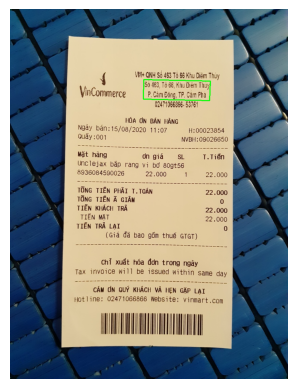

In [20]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# img_dir = Path('/home/azureuser/cloudfiles/code/dataset')
# mcocr_dir = img_dir/'mcocr_val_data/val_images'
# file_path = mcocr_dir/'mcocr_val_145114aszbc.jpg'
# Load your image
image = cv2.imread(str(file_path))
# Define your polygon points


# Convert points to a format that OpenCV can understand
points = np.array([(int(point.x), int(point.y)) 
                   for point in result.documents[0].fields
                    .get('VendorAddress')
                    .bounding_regions[0]
                    .polygon])

# Draw the polygon
cv2.polylines(image, [points], True, (0,255,0), thickness=2)

#Show the image with matplotlib

plt.imshow(image)
plt.axis('off')
plt.show()

